In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import cirq
import tensorflow_quantum as tfq
from utilities.circuit_basics import Basic
from utilities.evaluator import Evaluator
from utilities.variational import Minimizer
from utilities.discrimination import sdp_channel_disc
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
lower_bounds = []
pss = []

for eta0 in tqdm(np.arange(0,np.pi/2,np.pi/10)):

    eta1 = np.pi/2
    lower_bound = sdp_channel_disc([eta0, eta1])

    basic = Basic(n_qubits=3) #this is the module where basic functions are defined (and the rest of the modules inherits this classs)
    arguments={"problem":"QADC", "params":[eta0,eta1], "n_qubits":basic.n_qubits}
    evaluator = Evaluator(args = arguments, lower_bound_cost=lower_bound)
    optimizer = Minimizer(n_qubits=2, problem_config={"problem":"discrimination"}, lower_bound = lower_bound, lr=0.001, epochs=10**5, patience=1000)


    circuit=[]
    circuit = [basic.give_gate_template(k, block_id=0, trainable=True) for k in basic.u2(0,2)] ## begin from z rotation (nothing)
    circuit += basic.give_channel_circuit_db([0,1], eta=eta0, block_id=1)  
    circuit += [basic.give_gate_template(k, block_id=2, trainable=True) for k in basic.u2(0,2)]

    circuit, symbols, circuit_db = basic.give_circuit(circuit)
    batch = basic.prepare_channel_discrimination_circuits(circuit_db, eta1)

    cost_value, resolver, training_history = optimizer.channel_discrimination(batch)
    circuit_db = optimizer.update_circuit_db_param_values(circuit_db,resolver)
    evaluator.add_step(circuit_db, cost_value)

    pss.append(cost_value)
    lower_bounds.append(lower_bound)

100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


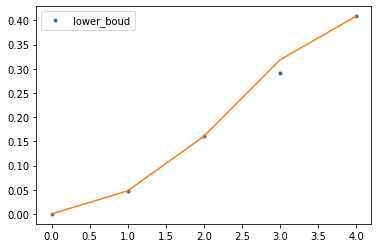

In [9]:
plt.plot(lower_bounds,'.' ,label="lower_boud")
plt.plot(pss)
plt.legend()